In [1]:
# Import modules and connect to a database
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%load_ext sql
%sql sqlite://

%matplotlib inline

In [2]:
# Load the drivers.csv file and create a table
drivers = pd.read_csv('formula-1-race-data-19502017/drivers.csv', encoding='ISO-8859-1')
%sql PERSIST drivers

 * sqlite://


'Persisted drivers'

## Table vs DataFrame
Notice the similarities between the two.

In [3]:
%sql SELECT * FROM drivers LIMIT 5;

 * sqlite://
Done.


index,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,07/01/1985,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,None,HEI,Nick,Heidfeld,10/05/1977,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,27/06/1985,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,29/07/1981,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,None,KOV,Heikki,Kovalainen,19/10/1981,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [4]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,07/01/1985,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,10/05/1977,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,27/06/1985,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,29/07/1981,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,19/10/1981,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## Problem 1
Find all Spanish drivers who were born after 1980. 

The "dob" column contains a string, so we can take a sub-string and compare it with '1980'.

In [5]:
%%sql

-- The substring dob[7:] is equivalent to year.

SELECT forename, surname, 
       dob AS birthdate
  FROM drivers 
 WHERE nationality = 'Spanish' 
   AND substr(dob,7) > '1980';

 * sqlite://
Done.


forename,surname,birthdate
Fernando,Alonso,29/07/1981
Jaime,Alguersuari,23/03/1990
Carlos,Sainz,01/09/1994
Roberto,Merhi,22/03/1991


## Problem 2
Find the number of drivers for each nationality.

Remove entries where count <= 10 and create a bar plot.

In [6]:
%%sql 

SELECT nationality, count
  FROM (SELECT nationality, 
               COUNT(*) AS count 
          FROM drivers 
         GROUP BY nationality) 
 WHERE count > 10;

 * sqlite://
Done.


nationality,count
American,157
Argentine,24
Australian,17
Austrian,15
Belgian,23
Brazilian,31
British,162
Canadian,13
Dutch,17
French,73


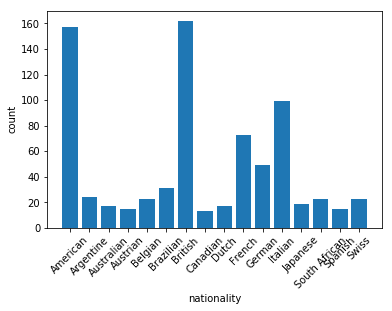

In [7]:
# Create a bar graph from the query result
_.bar();

## Problem 3
Find the most successful constructors in F1 by race wins and create a pie chart.

In [8]:
# Load two more tables
constr = pd.read_csv('formula-1-race-data-19502017/constructors.csv', encoding='ISO-8859-1')
%sql PERSIST constr

results = pd.read_csv('formula-1-race-data-19502017/results.csv', encoding='ISO-8859-1')
%sql PERSIST results

 * sqlite://
 * sqlite://


'Persisted results'

In [9]:
%%sql

-- Find the total number of race wins for each constructor.
-- Only keep the top 10, this makes it easier to view the pie chart.
-- A win here means position = 1.

SELECT name, COUNT(*) AS count
  FROM results AS r
       JOIN constr AS c
       ON r.constructorId = c.constructorId
 WHERE position = 1
 GROUP BY r.constructorId
 ORDER BY count DESC
 LIMIT 10;

 * sqlite://
Done.


name,count
Ferrari,230
McLaren,178
Williams,114
Mercedes,76
Red Bull,55
Team Lotus,45
Renault,35
Benetton,27
Tyrrell,23
Brabham,23


In [10]:
# We can do the same with Pandas to verify the results
df = results[results['position'] == 1]
df = df.groupby('constructorId').agg('count')
df = df.join(constr.set_index('constructorId'))

In [11]:
# Both methods produced the same result, but which one is easier to read?
df = df[['name', 'resultId']].sort_values('resultId', ascending=False)
df = df.head(10)
df

,name,resultId
constructorId,,
6,Ferrari,230
1,McLaren,178
3,Williams,114
131,Mercedes,76
9,Red Bull,55
32,Team Lotus,45
4,Renault,35
22,Benetton,27
25,Tyrrell,23


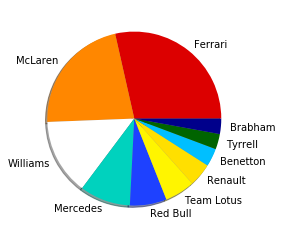

In [12]:
'''
Now we can produce a pie chart using the DataFrame.
Since Matplotlib allows us to specify colors in the pie chart, let's
find the colors that represent these teams.

Credits to www.f1colours.com and
www.reddit.com/r/formula1/comments/arxt0r/f1_2019_team_colors_hex_codes/
for the team colors.
'''

colors = ['#DC0000', '#FF8700', '#FFFFFF', '#00D2BE', '#1E41FF', 
          '#FFF500', '#FFDF00', '#00BFFF', '#006400', '#00008B']

plt.pie(df['resultId'], labels=df['name'], colors=colors, shadow=True);

## Problem 4
Find the most successful constructors in F1 by win rate.

In [13]:
%%sql 

-- Similar to the previous query, first find the number of race wins
-- Then compute the number of race entries and divide

WITH race_wins(consId, wins) AS 
     (SELECT constructorId, COUNT(*)
        FROM results
       WHERE position = 1
       GROUP BY constructorId)


SELECT name, 
       ROUND(1.0 * W.wins / COUNT(*), 3) AS win_rate
  FROM constr AS c
       JOIN results AS r
       ON c.constructorId = r.constructorId
        
       JOIN race_wins AS w
       ON r.constructorId = w.consId
 GROUP BY r.constructorId
 ORDER BY win_rate DESC
 LIMIT 10;

 * sqlite://
Done.


name,win_rate
Brawn,0.235
Matra-Ford,0.225
Mercedes,0.215
Vanwall,0.141
Watson,0.136
Epperly,0.118
Red Bull,0.112
McLaren,0.11
Ferrari,0.107
Brabham-Repco,0.104


## Problem 5
Is the number of races each season increasing?

In [14]:
# Load races.csv as a DataFrame
races = pd.read_csv('formula-1-race-data-19502017/races.csv', encoding='ISO-8859-1')
%sql PERSIST races
races.head()

 * sqlite://


,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [15]:
# Group by 'year'
df = races.groupby('year').aggregate('count').reset_index()

In [16]:
# Find a best fit line
fit = stats.linregress(df['year'], df['raceId'])
df['fit'] = fit.slope * df['year'] + fit.intercept

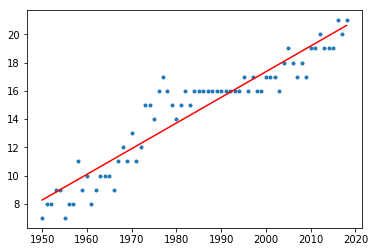

In [17]:
# Take a look at the results, is the slope increasing?
# We can find out by performing a hypothesis test
plt.plot(df['year'], df['raceId'], '.')
plt.plot(df['year'], df['fit'], 'r-')

In [18]:
# Chances of the slope being zero is...
fit.pvalue

5.430315536260765e-34

(array([ 5.,  8., 16., 11., 13.,  8.,  3.,  2.,  2.,  1.]),
 array([-2.26776276, -1.65865059, -1.04953842, -0.44042626,  0.16868591,
         0.77779808,  1.38691024,  1.99602241,  2.60513458,  3.21424674,
         3.82335891]),
 <a list of 10 Patch objects>)

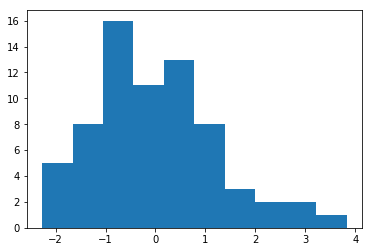

In [19]:
# Plot a histogram of the residuals
# Does this look reasonably normal?
plt.hist(df['raceId'] - df['fit'])

## Problem 6
Find all drivers that have won a drivers' championship title with Ferrari. 

In [20]:
%%sql

-- For every season, find each driver's total points.
-- Store the results of this query so we can use it again later.

CREATE TEMP TABLE standings(consId INT, drivId INT, year INT, points INT);

INSERT INTO Standings
SELECT constructorId, driverId, 
       year, SUM(points)
  FROM results AS re
  JOIN races AS ra
    ON re.raceId = ra.raceId
 GROUP BY driverId, year;

 * sqlite://
Done.
3059 rows affected.


[]

In [21]:
%%sql

-- The ones with the most points are the driver's champion.
-- Keep all entries where constructor name is Ferrari.

-- Räikkönen isn't showing properly, so replace the original value.

-- The sorting order of year is quite intersting.

WITH champions(consId, drivId, year) AS 
     (SELECT consId, drivId, 
             s.year
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
             AND s.points = ms.points)

    
SELECT forename, 
       REPLACE(surname,'RÌ_ikkÌ¦nen','Räikkönen') AS surname,
       d.nationality, 
       ch.year
  FROM champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year
Kimi,Räikkönen,Finnish,2007
Michael,Schumacher,German,2000
Michael,Schumacher,German,2001
Michael,Schumacher,German,2002
Michael,Schumacher,German,2003
Michael,Schumacher,German,2004
Niki,Lauda,Austrian,1975
Niki,Lauda,Austrian,1977
Jody,Scheckter,South African,1979
Phil,Hill,American,1961


## Problem 7
Some drivers were very close to winning a title with Ferrari.

Find the ones that lost by no more than five points.

In [22]:
%%sql

-- Similar to the previous query, but instead of finding standings where
-- points = MAX(points), find ones where 0 < (points - MAX(points)) <= 5.

WITH close_champions(consId, drivId, year, points) AS 
     (SELECT consId, drivId, 
             s.year,
             ms.points - s.points
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
       WHERE s.points <> ms.points
         AND ms.points - s.points <= 5)

SELECT forename, 
       surname,
       d.nationality, 
       ch.year,
       points
  FROM close_champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year,points
Fernando,Alonso,Spanish,2010,4
Fernando,Alonso,Spanish,2012,3
Felipe,Massa,Brazilian,2008,1
Michael,Schumacher,German,1997,3
Eddie,Irvine,British,1999,2
Alain,Prost,French,1990,5
Niki,Lauda,Austrian,1976,1
Didier,Pironi,French,1982,5
Clay,Regazzoni,Swiss,1974,3
Jacky,Ickx,Belgian,1970,5


In [23]:
%%sql

-- Now remove the temporary table that was created earlier.

DROP TABLE Standings;

 * sqlite://
Done.


[]

## Problem 8 
Find all drivers to win a race before the age of 24.

In [24]:
# Issue: driver's date of birth has a different format than race dates
# We must convert them to the same format

drivers['dob'].head(), races['date'].head()

(0    07/01/1985
 1    10/05/1977
 2    27/06/1985
 3    29/07/1981
 4    19/10/1981
 Name: dob, dtype: object, 0    2009-03-29
 1    2009-04-05
 2    2009-04-19
 3    2009-04-26
 4    2009-05-10
 Name: date, dtype: object)

In [25]:
# This can be fixed by reading the csv with parse_dates option

ddrivers = pd.read_csv('formula-1-race-data-19502017/drivers.csv', 
                      encoding='ISO-8859-1', parse_dates=['dob'])

%sql PERSIST ddrivers

draces = pd.read_csv('formula-1-race-data-19502017/races.csv', 
                      encoding='ISO-8859-1', parse_dates=['date'])

%sql PERSIST draces

ddrivers['dob'].head(), draces['date'].head()

 * sqlite://
 * sqlite://


(0   1985-07-01
 1   1977-10-05
 2   1985-06-27
 3   1981-07-29
 4   1981-10-19
 Name: dob, dtype: datetime64[ns], 0   2009-03-29
 1   2009-04-05
 2   2009-04-19
 3   2009-04-26
 4   2009-05-10
 Name: date, dtype: datetime64[ns])

In [35]:
%%sql 

-- Not quite right, we are missing Raikkonen, Kubica, and Fittipaldi
-- This could be a rounding error, as these drivers are included in
-- the results when date - dob < 25.

SELECT DISTINCT 
       forename, surname
  FROM results re
  JOIN ddrivers d
    ON re.driverId=d.driverId
    
  JOIN draces r
    ON re.raceId=r.raceId
 WHERE position=1
   AND date - dob < 24;

 * sqlite://
Done.


forename,surname
Lewis,Hamilton
Sebastian,Vettel
Fernando,Alonso
Michael,Schumacher
Jacky,Ickx
Bruce,McLaren
Troy,Ruttman
Max,Verstappen
